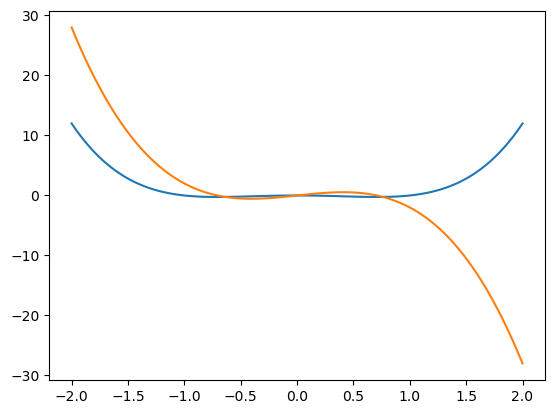

In [54]:
import propagators
import energy_landscapes
import long_simulation
import weighted_ensemble_2
import numpy as np
import MSM_methods
import analysis

import matplotlib.pyplot as plt
import importlib

#methods for fast print debugging
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

kT = 1
dt = 0.001
n_analysis_bins = 50
save_period = 100 #in steps
aggregate_simulation_limit = 10000000
#nsteps = 100000
n_parallel = 1000
n_bootstrap = 3

system1 = energy_landscapes.unit_double_well()
system1.plot_quantity(system1.potential)
system1.plot_quantity(system1.F)
#system1.analysis_bins(40)


<function long_simulation_histogram_analysis at 0x7fd5f22a0790>
round 0
round 1
round 2
<function long_simulation_hamsm_analysis at 0x7fd5f22a0700>
round 0
eigenvector converged to within 10^-12 after 0 rounds
round 1
eigenvector converged to within 10^-12 after 0 rounds
round 2
eigenvector converged to within 10^-12 after 0 rounds
<function weighted_ensemble_hamsm_analysis at 0x7fd5f22a05e0>
round 0
Each bin can hold up to 20 walkers, for a total of up to 1040 walkers
0
100
200
300
400
500
600
700
800
900
eigenvector converged to within 10^-12 after 0 rounds
round 1
Each bin can hold up to 20 walkers, for a total of up to 1040 walkers
0
100
200
300
400
500
600
700
800
900
eigenvector converged to within 10^-12 after 0 rounds
round 2
Each bin can hold up to 20 walkers, for a total of up to 1040 walkers
0
100
200
300
400
500
600
700
800
900
eigenvector converged to within 10^-12 after 0 rounds


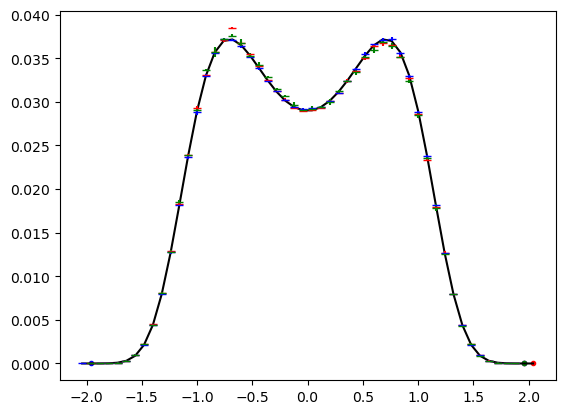

In [55]:
importlib.reload(analysis)
importlib.reload(long_simulation)
importlib.reload(weighted_ensemble_2)

mfpts_all, populations_all = analysis.bootstrap_method_comparison(3, [long_simulation.long_simulation_histogram_analysis, long_simulation.long_simulation_hamsm_analysis, weighted_ensemble_2.weighted_ensemble_hamsm_analysis], system1, kT, dt, aggregate_simulation_limit, n_parallel, save_period, n_analysis_bins)

analysis.plot_bootstrapping_results(populations_all, system1, kT, n_analysis_bins)

#TODO implement MFPT comparison
#TODO fast synthetic trajectories
#TODO clean up codebase generally; move this to v3 and then delete code below; make another notebook for synthetic trajectory development